# spatial_materials.
空間検索などに使用する材料を作成するモジュールを試す。

In [1]:
import os
import random
import sys
sys.path.append(os.pardir)

import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import shapely
from shapely.plotting import plot_points
from shapely.plotting import plot_polygon

from apps.spatial_materials import directional_fan
from apps.spatial_materials import directional_rectangle
from apps.spatial_materials import regular_hexagon
from apps.spatial_materials import regular_hexagon_gdf
from apps.projective_transformer import transform

## テストデータの作成

In [2]:
# 中心のPointを作成
lon = 140.46417575037228
lat = 40.60745754283918
coords = transform(lon, lat, 4326, 6678)
base_point = shapely.Point(coords.lon, coords.lat)

# ランダムなPointを作成
alphabet = 'ABCDEFG'
x_diffs = np.random.normal(0, scale=1_000, size=500)
y_diffs = np.random.normal(0, scale=1_000, size=500)

random_points = []
names = []
for xd, yd in zip(x_diffs, y_diffs):
    coords = (base_point.x + xd, base_point.y + yd)
    pt = shapely.Point(coords)
    random_points.append(pt)
    names.append(alphabet[random.randint(0, 6)])

point_gdf = gpd.GeoDataFrame(
    data={'name': names}, 
    geometry=random_points, 
    crs='EPSG:6678'
)

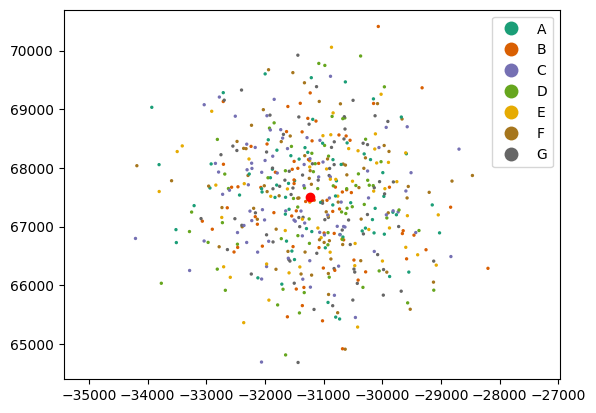

In [3]:
fig, ax = plt.subplots()
point_gdf.plot(
    column='name',
    markersize=2,
    cmap='Dark2',
    legend=True,
    ax=ax
)
ax.scatter(base_point.x, base_point.y, c='red')
ax.axis('equal');

## spatial_materials.directional_rectangle
---
ベース地点からある方向に向かって長方形のバッファーを作成する。

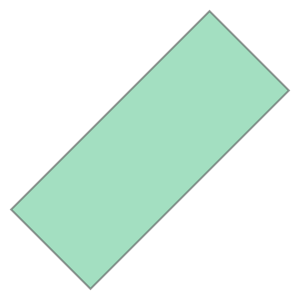

In [4]:
rectangle = directional_rectangle(base_point, distance=1500, angle=45, width=300)
rectangle

In [5]:
# GeoDataFrameに空間検索の結果を入力する
point_gdf['within_rectangle'] = point_gdf.intersects(rectangle)
point_gdf.head()

,name,geometry,within_rectangle
0,G,POINT (-32548.256 68371.167),False
1,B,POINT (-31544.931 67180.100),False
2,E,POINT (-30129.283 68321.419),True
3,A,POINT (-30972.425 66637.205),False
4,G,POINT (-30822.127 68055.232),True


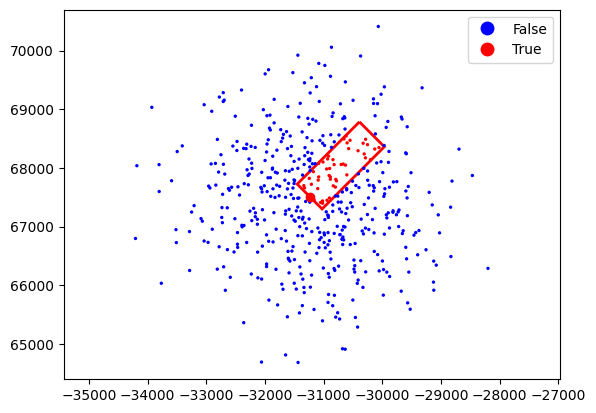

In [6]:
fig, ax = plt.subplots()
plot_polygon(rectangle, fill=None, color='red', linewidth=2, add_points=False, ax=ax)
point_gdf.plot(
    column='within_rectangle',
    markersize=2,
    cmap='bwr',
    legend=True,
    ax=ax
)
ax.scatter(base_point.x, base_point.y, c='red')
ax.axis('equal');


## spatial_materials.directional_fan
---
ベース地点から扇状のPolygonを作成する。

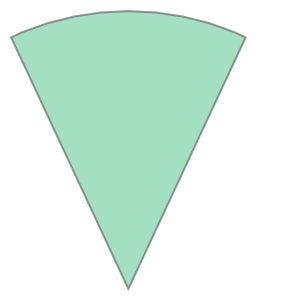

In [7]:
fan = directional_fan(base_point, distance=2000, angle1=335, angle2=25)
fan

In [8]:
# GeoDataFrameに空間検索の結果を入力する
point_gdf['within_fan'] = point_gdf.intersects(fan)
point_gdf.head()

,name,geometry,within_rectangle,within_fan
0,G,POINT (-32548.256 68371.167),False,False
1,B,POINT (-31544.931 67180.100),False,False
2,E,POINT (-30129.283 68321.419),True,False
3,A,POINT (-30972.425 66637.205),False,False
4,G,POINT (-30822.127 68055.232),True,False


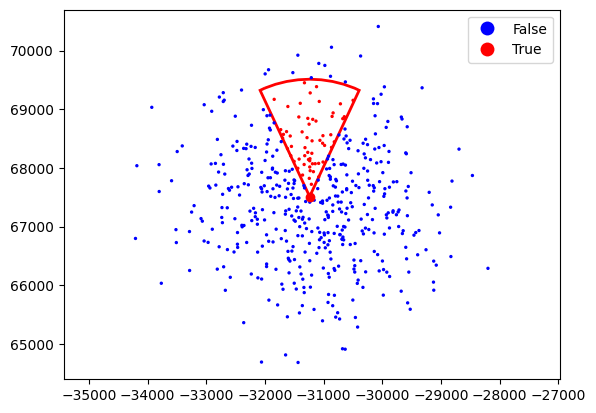

In [9]:
fig, ax = plt.subplots()
plot_polygon(fan, fill=None, color='red', linewidth=2, add_points=False, ax=ax)
point_gdf.plot(
    column='within_fan',
    markersize=2,
    cmap='bwr',
    legend=True,
    ax=ax
)
ax.scatter(base_point.x, base_point.y, c='red')
ax.axis('equal');

## spatial_materials.regular_hexagon
---
指定座標から指定した面積の正六角形のPolygonオブジェクトを作成する。

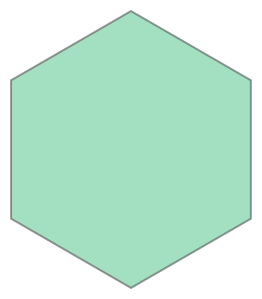

In [10]:
hexagon = regular_hexagon(hectare=5, center_x=base_point.x, center_y=base_point.y)
hexagon

In [11]:
area = round(hexagon.area / 10_000, 5)
print(f'Hectare: {area}')

Hectare: 5.0


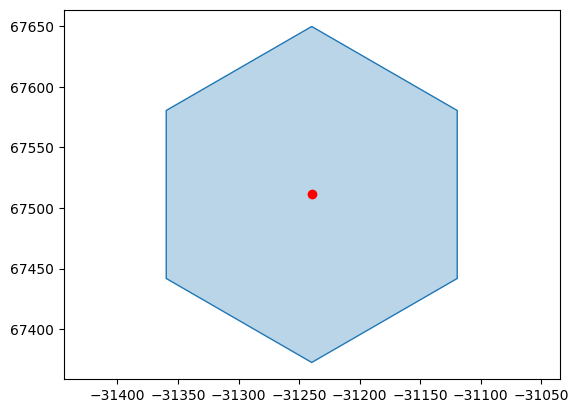

In [12]:
fig, ax = plt.subplots()
plot_polygon(hexagon, ax=ax, add_points=False)
plot_points(base_point, color='red', ax=ax);
ax.axis('equal');

## spatial_materials.regular_hexagon_gdf
---
指定範囲全体に指定した面積の正六角形のPolygonオブジェクトを作成する。

In [13]:
multi_point = shapely.MultiPoint(random_points)
hexg_gdf = regular_hexagon_gdf(hectare=10, geometry=multi_point, margin=20)
hexg_gdf.head()

,rows_idx,cols_idx,unique_id,geometry
0,0,0,0-0,"POLYGON ((-34228.212 70626.199, -34058.308 705..."
1,0,1,0-1,"POLYGON ((-33888.403 70626.199, -33718.499 705..."
2,0,2,0-2,"POLYGON ((-33548.594 70626.199, -33378.690 705..."
3,0,3,0-3,"POLYGON ((-33208.786 70626.199, -33038.881 705..."
4,0,4,0-4,"POLYGON ((-32868.977 70626.199, -32699.072 705..."


In [14]:
hexg_gdf.area / 10_000

0      9.999997
1      9.999997
2      9.999997
3      9.999997
4      9.999997
         ...   
404    9.999997
405    9.999997
406    9.999997
407    9.999997
408    9.999997
Length: 409, dtype: float64

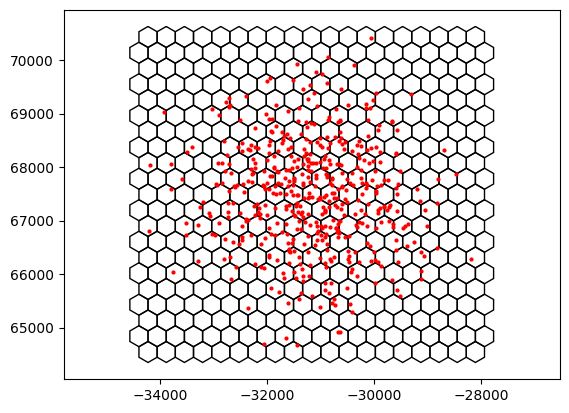

In [15]:
fig, ax = plt.subplots()
for geom in hexg_gdf.geometry:
    plot_polygon(geom, add_points=False, fill=None, color='black', ax=ax)
plot_points(multi_point, markersize=2, color='red', ax=ax)
ax.axis('equal');

touchesメソッドで回りの六角形を取得してみましょう。

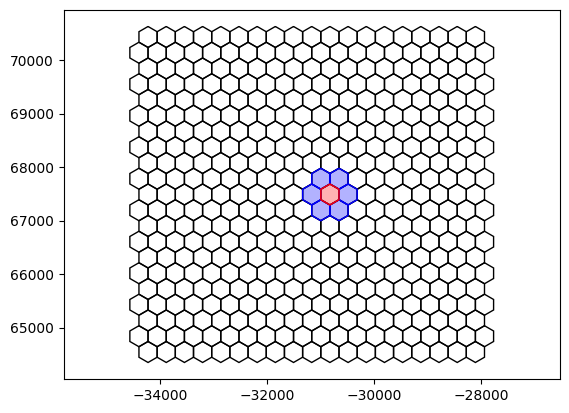

In [18]:
fig, ax = plt.subplots()
for hexg in hexg_gdf.geometry:
    plot_polygon(hexg, fill=None, color='black', add_points=False, ax=ax)

trg_hexg = hexg_gdf.geometry.iloc[205]
for hexg in hexg_gdf[hexg_gdf.touches(trg_hexg)].geometry:
    plot_polygon(hexg, color='blue', add_points=False, ax=ax)

plot_polygon(trg_hexg, color='red', add_points=False, ax=ax)
ax.axis('equal');

空間検索で区画ごとにPointの数を数える

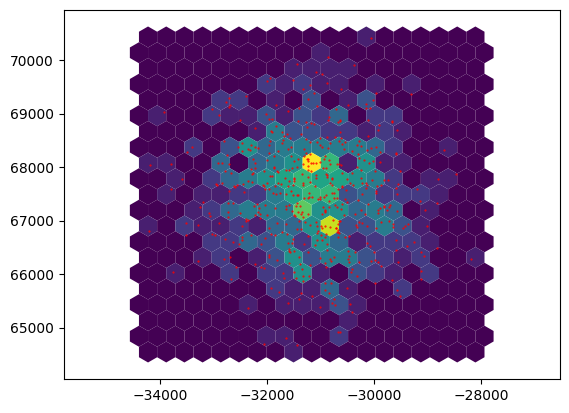

In [25]:
def count_points(poly: shapely.Polygon, point_gdf: gpd.GeoDataFrame):
    # Community内の放置車両の数を数えます
    count = point_gdf[poly.intersects(point_gdf.geometry)].shape[0]
    return count


hexg_gdf['count'] = (
    hexg_gdf.geometry
    .apply(lambda geom:count_points(geom, point_gdf))
)

fig, ax = plt.subplots()
hexg_gdf.plot(
    column='count',
    cmap='viridis',
    ax=ax 
)
plot_points(point_gdf.geometry, markersize=0.5, color='red', ax=ax)
ax.axis('equal');